In [1]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
import yfinance as yf


In [2]:
from scipy.io import loadmat

import h5py

import numpy as np
import h5py
f = h5py.File('nyse-n.mat','r')
data = f.get('data')
data = np.array(data)
data

array([[0.99751   , 1.00994   , 0.99753   , ..., 0.99315069, 0.97931035,
        1.        ],
       [0.98648   , 1.01371   , 0.96957   , ..., 0.98214286, 0.93636364,
        0.97087379],
       [0.9922    , 1.00198   , 0.98433   , ..., 0.98578199, 0.95913461,
        0.97994987],
       ...,
       [0.98684   , 0.99333   , 1.00224   , ..., 1.01349073, 0.99500832,
        0.99498328],
       [0.99671   , 0.95396   , 0.99654   , ..., 0.98453608, 0.95986038,
        1.00545455],
       [1.00892   , 0.99116   , 1.00448   , ..., 0.99439776, 0.9915493 ,
        0.98153409]])

In [7]:
### GET STOCK DATA

tickers = ['AAPL', 'TSLA', 'KO', 'WBA', 'WMT', 'DKS', 'GOOGL', 'MSFT','PG',"HD"]
num_stocks = len(tickers)

data_mat = []

for ticker in tickers:
    data = yf.download(ticker, '2016-01-01', '2018-01-01') #,'2018-01-01')
    data_mat.append(data.Close.values / data.Open.values)
    
data = np.array(data_mat)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


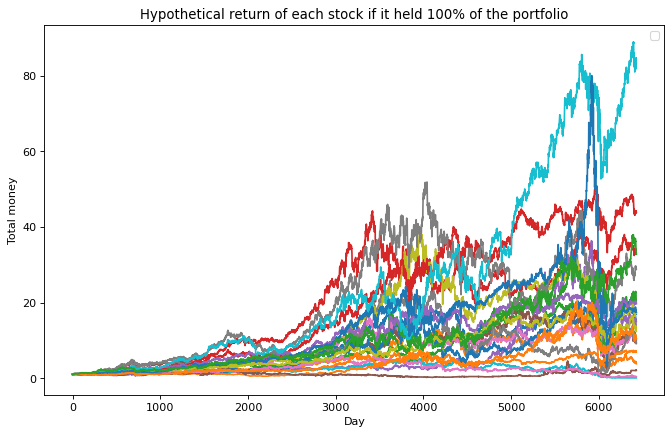

In [14]:
# Get hypothetical returns of each stock if that stock got all the money

initial_money = 1 # start with $100
overall_returns = initial_money * np.cumprod(data, axis=1)

plt.figure(num=None, figsize=(10, 6), dpi=80, facecolor='w', edgecolor='k')
for ii in range(data.shape[0]):
    plt.plot(overall_returns[ii, :])#, label = tickers[ii])
plt.legend()
plt.xlabel("Day")
plt.ylabel("Total money")
plt.title("Hypothetical return of each stock if it held 100% of the portfolio")
plt.savefig("./unistock_portfolio_returns.png")
plt.show()

In [3]:
num_stocks = data.shape[0]
data

array([[0.99751   , 1.00994   , 0.99753   , ..., 0.99315069, 0.97931035,
        1.        ],
       [0.98648   , 1.01371   , 0.96957   , ..., 0.98214286, 0.93636364,
        0.97087379],
       [0.9922    , 1.00198   , 0.98433   , ..., 0.98578199, 0.95913461,
        0.97994987],
       ...,
       [0.98684   , 0.99333   , 1.00224   , ..., 1.01349073, 0.99500832,
        0.99498328],
       [0.99671   , 0.95396   , 0.99654   , ..., 0.98453608, 0.95986038,
        1.00545455],
       [1.00892   , 0.99116   , 1.00448   , ..., 0.99439776, 0.9915493 ,
        0.98153409]])

In [4]:
# gets the total return for a given portfolio b
def portfolio_wealth(b, stock_data):
    return np.prod(np.dot(b, stock_data))

# function for retrieving all possible portfolios at a certain level of granularity
def binnings(n, k, cache={}):
    if n == 0:
        return np.zeros((1, k))
    if k == 0:
        return np.empty((0, 0))
    args = (n, k)
    if args in cache:
        return cache[args]
    a = binnings(n - 1, k, cache)
    a1 = a + (np.arange(k) == 0)
    b = binnings(n, k - 1, cache)
    b1 = np.hstack((np.zeros((b.shape[0], 1)), b))
    result = np.vstack((a1, b1))
    cache[args] = result
    return result

In [9]:
all_portfolio_allocations = binnings(36, 2)

In [39]:
## COMPUTE ALL POSSIBLE PORTFOLIOS

allocation_granularity = 1
all_portfolio_allocations = binnings(allocation_granularity, num_stocks)
row_sums = all_portfolio_allocations.sum(axis=1)
all_portfolios = all_portfolio_allocations / row_sums[:,np.newaxis]

In [35]:
data=data[:,1:3100]

In [12]:
all_portfolios

array([[1.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
       [0.95, 0.05, 0.  , ..., 0.  , 0.  , 0.  ],
       [0.95, 0.  , 0.05, ..., 0.  , 0.  , 0.  ],
       ...,
       [0.  , 0.  , 0.  , ..., 0.  , 0.1 , 0.9 ],
       [0.  , 0.  , 0.  , ..., 0.  , 0.05, 0.95],
       [0.  , 0.  , 0.  , ..., 0.  , 0.  , 1.  ]])

In [40]:
## RUN UNIVERSAL PORTFOLIO
from tqdm import tqdm

initial_money = 1
curr_portfolio = np.ones(data.shape[0]) * 1.0 / data.shape[0] # uniform
used_portfolios = []
money_per_stock = []
total_money_trace = []
money_per_stock.append(curr_portfolio * initial_money)
used_portfolios.append(curr_portfolio)


## run the algorithm
for tt in tqdm(range(data.shape[1])):
    
    ## calculate returns
    curr_return = np.multiply(data[:, tt], money_per_stock)
    total_money = np.sum(curr_return)
    total_money_trace.append(total_money)
    
    ## compute the updated portfolio
    portfolio_weights = np.array([portfolio_wealth(x, data[:, :tt+1]) for x in list(all_portfolios)])
    weighted_portfolio = np.dot(portfolio_weights, all_portfolios)
    curr_portfolio = weighted_portfolio / np.sum(portfolio_weights)
    used_portfolios.append(curr_portfolio)
    
    ## rebalance the money
    money_per_stock = curr_portfolio * total_money
    

    
## compute the best "buy and hold" strategy
buy_and_hold_returns = np.prod(data, axis=1)
    
## compute the best constant rebalanced portfolio in hindsight


100%|██████████| 3099/3099 [00:02<00:00, 1345.79it/s]


In [31]:
print(buy_and_hold_returns * initial_money)
print(np.sum(money_per_stock))
print(curr_portfolio)

[152.98383177  77.89258883 127.33536553  86.56080849 162.30671653]
119.89548815390653
[0.21317957 0.18184894 0.20335339 0.18514471 0.21647339]


In [13]:
## compute earnings for buy and holds

buy_and_hold_money = initial_money * np.cumprod(data, axis=1)

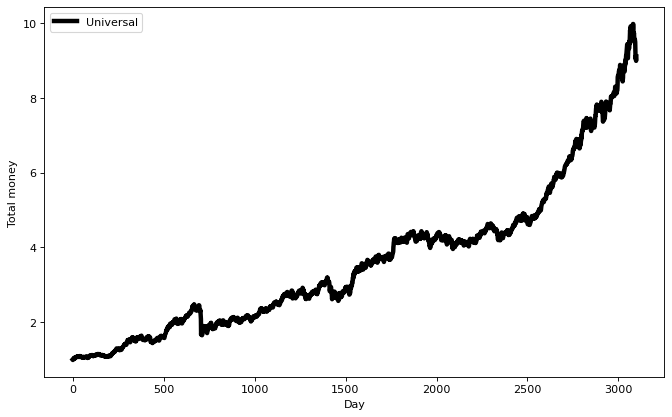

In [41]:
## compare buy and hold to universal portfolio

plt.figure(num=None, figsize=(10, 6), dpi=80, facecolor='w', edgecolor='k')


# for ii in range(buy_and_hold_money.shape[0]):
#     plt.plot(buy_and_hold_money[ii, :])
    
plt.plot(total_money_trace, 'black', label="Universal", linewidth=4)
plt.legend()
plt.xlabel("Day")
plt.ylabel("Total money")
plt.savefig('./universal_vs_bh.png')
plt.show()

In [42]:
total_money_trace[-1]

9.108484679340945

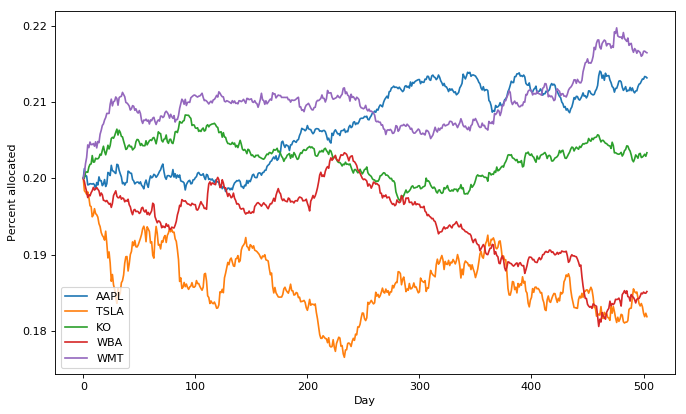

In [281]:
## look at evolution of universal portfolio over time

plt.figure(num=None, figsize=(10, 6), dpi=80, facecolor='w', edgecolor='k')

used_portfolios = np.array(used_portfolios)

for ii in range(used_portfolios.shape[1]):
    
    plt.plot(used_portfolios[:, ii], label = tickers[ii])
    
plt.xlabel("Day")
plt.ylabel("Percent allocated")
plt.legend()
plt.savefig('./universal_over_time.png')
plt.show()

In [38]:
# calculate returns for each constant balanced portfolio
portfolio_hindsight_earnings = []
for p in all_portfolios:
    curr_w = portfolio_wealth(p, data)
    portfolio_hindsight_earnings.append(curr_w)

In [39]:
np.max(portfolio_hindsight_earnings) * 100

162.30671653464205

In [41]:
# check best constant balanced portfolio
all_portfolios[np.argmax(portfolio_hindsight_earnings)]

array([0., 0., 0., 0., 1.])

Here's an example of a best constant rebalanced portfolio that isn't a buy and hold strategy. Consider the wildly varying stocks that give returns bouncing between 2 and 1/2.

In [53]:
data1 = np.vstack([np.tile([2, 0.5], 5), np.tile([0.5, 2], 5)])

allocation_granularity = 10
all_portfolio_allocations = binnings(allocation_granularity, 2)
row_sums = all_portfolio_allocations.sum(axis=1)
all_portfolios1 = all_portfolio_allocations / row_sums[:, np.newaxis]


portfolio_hindsight_earnings = []
for p in all_portfolios1:
    curr_w = portfolio_wealth(p, data1)
    portfolio_hindsight_earnings.append(curr_w)

In [54]:
print("Best in hindsight: {}".format(all_portfolios1[np.argmax(portfolio_hindsight_earnings)]))

Best in hindsight: [0.5 0.5]


In [55]:
# Plot earnings of buy and hold strategy and rebalanced half-half strategy

initial_money = 100

## ---- Buy and hold ------
buy_hold_returns = initial_money * np.cumprod(data1, axis=1)


## ------ Half and half ------
curr_portfolio = np.ones(data1.shape[0]) * 1.0 / data1.shape[0] # uniform
money_per_stock = []
total_money_trace = []
money_per_stock.append(curr_portfolio * initial_money)
used_portfolios.append(curr_portfolio)


## run the algorithm
for tt in range(data1.shape[1]):
    
    ## calculate returns
    curr_return = np.multiply(data1[:, tt], money_per_stock)
    total_money = np.sum(curr_return)
    total_money_trace.append(total_money)
    
    ## rebalance the money
    money_per_stock = curr_portfolio * total_money

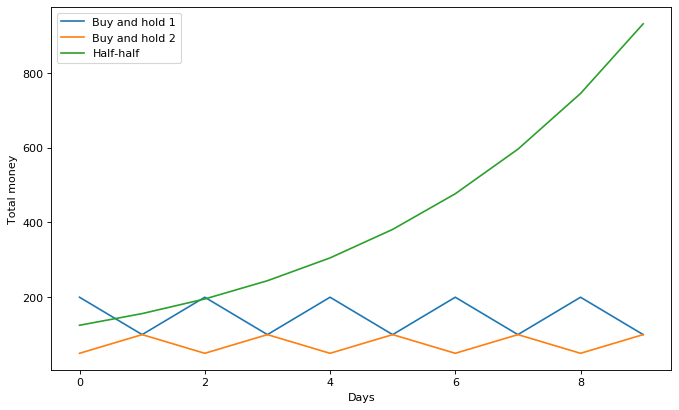

In [59]:
plt.figure(num=None, figsize=(10, 6), dpi=80, facecolor='w', edgecolor='k')


## ---- Plot buy and hold -------
for ii in range(buy_hold_returns.shape[0]):
    plt.plot(buy_hold_returns[ii, :], label = "Buy and hold {}".format(ii+1))
    
## ----- Plot half and half -----
plt.plot(total_money_trace, label = "Half-half")
plt.xlabel("Days")
plt.ylabel("Total money")
plt.legend()
plt.savefig("./bouncy_stocks_returns.png")
plt.show()